In [266]:
import numpy as np
import pandas as pd
import scipy as sp
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt

from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import metrics

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import tensorflow.keras as keras
from keras.models import load_model

import time
import os
import sys
import pickle

# append the path to the file that contains utility functions for organizing the data
from modelFitUtils import *


In [2]:
ME_db_fname = "mesh_NoArt_ME_db_128.pickle"

t1 = time.time()
with open(ME_db_fname, "rb") as f:
    ME_db_2Dmesh = pickle.load(f)
print("Loaded %s database in %f s" % (ME_db_fname, time.time()-t1))

with open("CascadeModel_trainData.pickle", "rb") as f:
    db = pickle.load(f)

nClas = len(ME_db_2Dmesh)
nTrials = ME_db_2Dmesh[1].shape[0]
nFrames = ME_db_2Dmesh[1].shape[1]
nX = ME_db_2Dmesh[1].shape[2]
nY = ME_db_2Dmesh[1].shape[3]
print("There are: \n %.f   Classes, \n %.f Trials/Class, \n %.f TimePoints/Trial, \n %.fx%.f Datashape/TimePoint" % (nClas, nTrials, nFrames, nX, nY))

Loaded mesh_NoArt_ME_db_128.pickle database in 1.227690 s
There are: 
 7   Classes, 
 749 Trials/Class, 
 257 TimePoints/Trial, 
 9x9 Datashape/TimePoint


In [3]:
S = 8    # S = number of images
h_states_lstm = 64
dropout_rate = 0.5
learning_rate = 1e-4
nTrial_class = nTrials
opt = "adam"
lossfn = 'categorical_crossentropy'
metric = ['acurracy']
nEpochs = 50

In [120]:
def setupDataForNetwork2(inputs, targets, classes, testSize=0.2):
    # convert target labels to be in ascending order starting from 1
    j = 1
    for c in classes:
        targets[:] = [x if x != c else j for x in targets]
        j = j+1
    # split into training and testing set
    X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=testSize)
    # add an depth dimension
    X_train = np.expand_dims(X_train, axis=-1)
    X_test = np.expand_dims(X_test, axis=-1)

    # set any channel with nans to 0
    where_are_NaNs = np.isnan(X_train)
    X_train[where_are_NaNs] = 0
    where_are_NaNs = np.isnan(X_test)
    X_test[where_are_NaNs] = 0

    return X_train, X_test, y_train, y_test

In [74]:
class2Cons = [1,2,3,4,5,6,7]
nX = ME_db_2Dmesh[1].shape[2]
nY = ME_db_2Dmesh[1].shape[3]
nPointsPerTrial = ME_db_2Dmesh[1].shape[1]

# convert ehd data into sliding windows
windows = sliding_window(np.arange(nPointsPerTrial), S, S//2)
nWin = windows.shape[0]
inputs, targets, wins  = genAllDat(ME_db_2Dmesh, windows, class2Cons, len(class2Cons), nTrials, nWin, S, nX, nY, rand=False)

In [75]:
#plt.plot(wins[0:100])
targets.shape[0]/749

InputsByClassTime = []
for clas in class2Cons:
    # loop through each time bin
    timeBins = np.zeros((np.max(wins), nTrial_class, S, nX, nY))
    for b in range(np.min(wins), np.max(wins)+1):
        timeBins[b-1][:,:,:] = inputs[np.logical_and(wins==b, targets==clas)][:,:,:]
        #timeBins.append(inputs[np.logical_and(wins==b, targets==clas)][:,:,:])
        
    InputsByClassTime.append(timeBins)

In [131]:
InputsByClassTime[0].shape
#targets.shape
#np.zeros(InputsByClassTime[0].shape[1]).shape

(62, 749, 8, 9, 9)

In [262]:
saved_model= load_model('CascadeModel_S8_C1to7_Epochs50.h5')#layer = 'dense_6'
opt = keras.optimizers.Adam(learning_rate=1e-4)
saved_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
saved_model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_7 (TimeDist (None, 8, 9, 9, 32)       320       
_________________________________________________________________
time_distributed_8 (TimeDist (None, 8, 9, 9, 64)       18496     
_________________________________________________________________
time_distributed_9 (TimeDist (None, 8, 9, 9, 128)      73856     
_________________________________________________________________
time_distributed_10 (TimeDis (None, 8, 10368)          0         
_________________________________________________________________
time_distributed_11 (TimeDis (None, 8, 1024)           10617856  
_________________________________________________________________
time_distributed_12 (TimeDis (None, 8, 1024)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 8, 8)             

C:\Users\Liangyu\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [247]:
currClass = 6
tBin = 31
nBins = np.max(wins)
allAccuracy = np.zeros((10,7,nBins+1))
for k in range(0,10):
    for c in range(0,7):
        display("K="+str(k)+", class"+str(c+1))
        for t in range(0,nBins+1):

            currInput = InputsByClassTime[currClass][tBin]
            currlabels = currClass*np.ones(InputsByClassTime[currClass].shape[1])
            X_train, X_test, y_train, y_test = setupDataForNetwork2(currInput, currlabels, [currClass],testSize = 0.9)

            y_train = y_train*currClass
            y_train = np.append(y_train,6)
            targetsOneHot = np.delete(to_categorical(y_train),-1,axis=0)

            _, accuracy = saved_model.evaluate(X_train, targetsOneHot, batch_size=64, verbose=0)

            allAccuracy[k,c,t] = accuracy


'K=0, class1'

'K=0, class2'

'K=0, class3'

'K=0, class4'

'K=0, class5'

'K=0, class6'

'K=0, class7'

'K=1, class1'

'K=1, class2'

'K=1, class3'

'K=1, class4'

'K=1, class5'

'K=1, class6'

'K=1, class7'

'K=2, class1'

'K=2, class2'

'K=2, class3'

'K=2, class4'

'K=2, class5'

'K=2, class6'

'K=2, class7'

'K=3, class1'

'K=3, class2'

'K=3, class3'

'K=3, class4'

'K=3, class5'

'K=3, class6'

'K=3, class7'

'K=4, class1'

'K=4, class2'

'K=4, class3'

'K=4, class4'

'K=4, class5'

'K=4, class6'

'K=4, class7'

'K=5, class1'

'K=5, class2'

'K=5, class3'

'K=5, class4'

'K=5, class5'

'K=5, class6'

'K=5, class7'

'K=6, class1'

'K=6, class2'

'K=6, class3'

'K=6, class4'

'K=6, class5'

'K=6, class6'

'K=6, class7'

'K=7, class1'

'K=7, class2'

'K=7, class3'

'K=7, class4'

'K=7, class5'

'K=7, class6'

'K=7, class7'

'K=8, class1'

'K=8, class2'

'K=8, class3'

'K=8, class4'

'K=8, class5'

'K=8, class6'

'K=8, class7'

'K=9, class1'

'K=9, class2'

'K=9, class3'

'K=9, class4'

'K=9, class5'

'K=9, class6'

'K=9, class7'

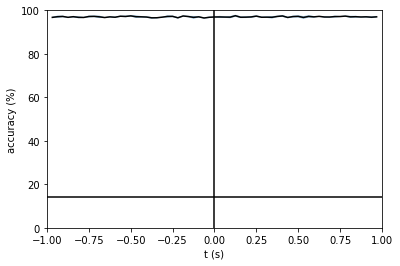

In [254]:
mean = np.mean(np.mean(allAccuracy*100, axis=0), axis=0)
standard_dev = np.std(np.std(allAccuracy*100, axis=0), axis=0)
binLabels = np.arange(-31*(S/2)/128,32*(S/2)/128,S/2/128)
plt.fill_between(binLabels, mean-standard_dev, mean+standard_dev, alpha = 0.5)
plt.plot(binLabels,mean,'k')
plt.plot([-1, 1],[1/7*100, 1/7*100],'k')
plt.plot([0, 0],[0, 100],'k')
plt.ylim((0, 100))
plt.xlim((-1, 1))
plt.xlabel("t (s)")
plt.ylabel("accuracy (%)")
plt.savefig('ClassificationAcrossBins.pdf')

(-1, 1)

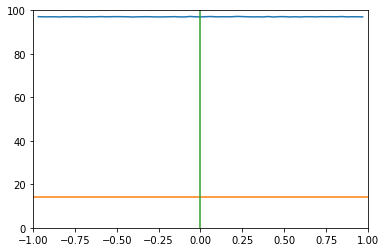

In [245]:
#plt.plot(allAccuracy[0,:])
#plt.plot(np.mean(allAccuracy, axis=0))
#plt.plot(np.std(allAccuracy, axis=0))
mean = np.mean(allAccuracy*100, axis=0)
standard_dev = np.std(allAccuracy*100, axis=0)
binLabels = np.arange(-31*(S/2)/128,32*(S/2)/128,S/2/128)
#plt.fill_between(binLabels, mean-standard_dev, mean+standard_dev, alpha = 0.5)
plt.plot(binLabels,mean)
plt.plot([-1, 1],[1/7*100, 1/7*100])
plt.plot([0, 0],[0, 100])
#plt.plot(binLabels,np.transpose(allAccuracy)*100)
plt.ylim((0, 100))
plt.xlim((-1, 1))


In [ ]:
with open("CascadeModel_trainData.pickle", "rb") as f:
    Dataset = pickle.load(f)
    
X_train = Dataset[0]
X_test = Dataset[1]
y_train = Dataset[2]
y_test = Dataset[3]

In [263]:
class2Cons = [1,2,3,4,5,6,7]
nClasses = len(class2Cons)
display(class2Cons)

#X_train, X_test, y_train, y_test = setupDataForNetwork(ME_db_2Dmesh, class2Cons, S, S//2, nTrial_class)

predictions = saved_model.predict(X_test,batch_size=64, verbose=1)
predictions.argmax(axis=1).shape

[1, 2, 3, 4, 5, 6, 7]

66062/66062 [==============================] - 126s 2ms/step


(66062,)

In [265]:
predictions[0:5,:]

array([[1.24585559e-03, 4.15164046e-03, 8.35484445e-01, 6.65378645e-02,
        1.35203665e-02, 7.82415196e-02, 8.18264205e-04],
       [9.89283681e-01, 4.22796933e-03, 3.61829843e-05, 7.95081505e-05,
        1.84170168e-03, 3.84124485e-03, 6.89636392e-04],
       [1.07743348e-09, 6.37141920e-06, 9.99982357e-01, 6.02465707e-06,
        2.16071655e-07, 5.05388152e-06, 3.36176087e-11],
       [3.76481040e-07, 7.38855158e-11, 2.19801222e-09, 1.04231083e-06,
        9.99998450e-01, 1.50764933e-07, 5.20527686e-13],
       [1.10377534e-03, 9.85433944e-05, 1.60152965e-07, 2.20284594e-04,
        6.81088786e-05, 1.25648943e-03, 9.97252643e-01]], dtype=float32)

In [200]:
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues, saveFit=False, figName='test.pdf'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    if normalize:
        im = ax.imshow(cm, interpolation='nearest', vmin=0, vmax=1, cmap=cmap)
    else:
        im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.xlim(-0.5, len(np.unique(y_true))-0.5)
    plt.ylim(len(np.unique(y_true))-0.5, -0.5)
    
    if saveFit:
        plt.savefig(figName)
    return plt, ax

Confusion matrix, without normalization
[[35178   786   324   194   375   148   703]
 [  519 35576   459   478    74   173   411]
 [  321   718 35500   351   386   286   206]
 [  121   657   273 35354   157   437   594]
 [  508   116   657   210 35245   557   464]
 [  104   304   338   812   376 35703   295]
 [  451   398   127   453   240   166 35964]]
Normalized confusion matrix
[[0.93290548 0.02084438 0.00859234 0.0051448  0.00994484 0.0039249
  0.01864326]
 [0.01377023 0.94391085 0.0121783  0.01268241 0.00196339 0.00459008
  0.01090475]
 [0.00849926 0.0190108  0.93994916 0.00929358 0.01022029 0.00757255
  0.00545435]
 [0.00321868 0.01747666 0.00726199 0.94044104 0.00417631 0.0116245
  0.01580081]
 [0.01345446 0.00307228 0.01740075 0.00556188 0.93346929 0.01475223
  0.01228911]
 [0.00274175 0.00801434 0.00891068 0.02140673 0.00991247 0.94123695
  0.00777707]
 [0.01193153 0.01052938 0.00335988 0.01198444 0.00634937 0.00439165
  0.95145374]]


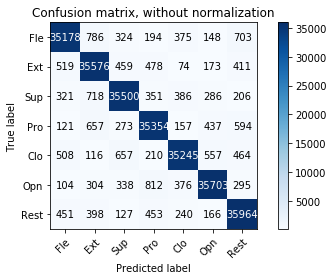

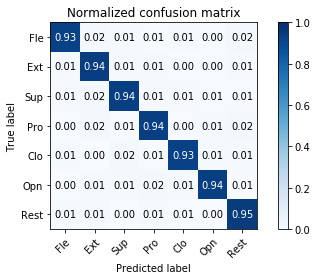

In [183]:
#np.set_printoptions(precision=2)
class_names = np.array(['Fle', 'Ext', 'Sup', 'Pro', 'Clo','Opn','Rest'])
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_train-1, predictions.argmax(axis=1), classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_train-1, predictions.argmax(axis=1), classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Normalized confusion matrix
[[0.84365029 0.03775792 0.02063391 0.01393321 0.02605829 0.0252074
  0.03275899]
 [0.03185265 0.85222102 0.04734561 0.01375948 0.01213434 0.0099675
  0.03271939]
 [0.01756771 0.03492628 0.85475269 0.03022064 0.01892711 0.03022064
  0.01338492]
 [0.02132151 0.01625501 0.04749842 0.82256703 0.03082119 0.0180494
  0.04348744]
 [0.02641429 0.01582718 0.02545182 0.03144049 0.85477489 0.02641429
  0.01967704]
 [0.02373451 0.01081706 0.03938248 0.01081706 0.02320941 0.8600084
  0.03203109]
 [0.02195378 0.04065126 0.01512605 0.02794118 0.01008403 0.0262605
  0.85798319]]


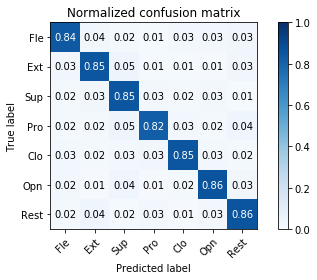

In [264]:
plt,ax =plot_confusion_matrix(y_test-1, predictions.argmax(axis=1), classes=class_names, normalize=True,
                      title='Normalized confusion matrix', saveFit=True, figName='ConfusionMatrix.pdf')


In [192]:
ax

array([[35178,   519,   321,   121,   508,   104,   451],
       [  786, 35576,   718,   657,   116,   304,   398],
       [  324,   459, 35500,   273,   657,   338,   127],
       [  194,   478,   351, 35354,   210,   812,   453],
       [  375,    74,   386,   157, 35245,   376,   240],
       [  148,   173,   286,   437,   557, 35703,   166],
       [  703,   411,   206,   594,   464,   295, 35964]], dtype=int64)

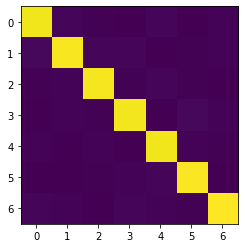

In [169]:
from sklearn.metrics import confusion_matrix
confusionMatrix = confusion_matrix(predictions.argmax(axis=1)+1, y_train)
plt.imshow(confusionMatrix)
confusionMatrix

In [ ]:
class2Cons = [1,2,3,4,5,6,7]
nClasses = len(class2Cons)
display(class2Cons)

X_train, X_test, y_train, y_test = setupDataForNetwork(ME_db_2Dmesh, class2Cons, S, S//2, nTrial_class)

# define model
model = cascadeModel(X_train, nClasses, dropout_rate=dropout_rate, opt=keras.optimizers.Adam(learning_rate=learning_rate))

# define early stopping and checkpoints
from keras.callbacks import ModelCheckpoint, EarlyStopping
outputFile = output_dir+"/CascadeModel_S"+str(S)+"_C1to7_"+"Epochs"+str(nEpochs)+".h5"
checkpoint = ModelCheckpoint(outputFile, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

# fit network
targetsOneHot = to_categorical(y_train-1)
history = model.fit(X_train, targetsOneHot, epochs=nEpochs, batch_size=64, verbose=1, validation_split=0.2, callbacks=[checkpoint, early])
# evaluate model
targetsOneHot = to_categorical(y_test-1)
_, accuracy = model.evaluate(X_test, targetsOneHot, batch_size=64, verbose=1)
display(accuracy)

# save the fitting history to a file
with open(output_dir+"/CascadeModel_trainHistoryDict", 'wb') as file_pi:
  pickle.dump(history.history, file_pi)

